# Developing Pyreal Applications

In this tutorial, we will be going through the process of putting together a RealApp object for future use.

If you have not already tried Demonstration 1: Using Pyreal, please do so before trying this demo, to better understand the purpose of RealApp objects.

## Scenario Details
### Goals for this Scenario
1. Learn the components of a Pyreal RealApp, and the steps required to create one for your target application
2. Learn about Pyreal's built-in Transformers, and how to make custom, application-specific transformers

### User Details

- **User Role:** ML Engineer for Real Estate Firm
- **Expertise:**
    - **Domain (House Pricing):** Some experience
    - **Machine Learning:** Expert
    - **Explainable ML techniques:** Basic understanding
- **User Goals:**
    1. Understand what features contribute to average block prices in California

### Model and Data Details
- 9 Features
- Predicts average price of block of houses

## Data Loading

We will begin by loading in our data matrix and targets, and taking a look at the data


In [29]:
n_rows = 500

In [30]:
from pyreal.sample_applications import california_housing
import pandas as pd

X, y = california_housing.load_data(n_rows)
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY
...,...,...,...,...,...,...,...,...,...
495,-122.25,37.86,52,4048,663.0,1316,590,5.3794,NEAR BAY
496,-122.26,37.85,52,3618,768.0,1508,755,3.2619,NEAR BAY
497,-122.27,37.85,52,4076,920.0,1800,815,2.7054,NEAR BAY
498,-122.27,37.85,47,2077,400.0,719,326,2.2431,NEAR BAY


## Current State: Explaining Without Pyreal
Let's start by fitting some transformers, training a model, and trying to generate a global explanation of our model without using Pyreal, so we have a point of comparison for both coding effort and explanation quality over just using ML and explanation algorithms directly.

First, we transform the data and train a basic Perceptron...

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_transform = X.copy()

# One-hot encode ocean_proximity to be compatible with model
ohe = OneHotEncoder(sparse_output=False)
ohe_cols = ohe.fit_transform(X_transform[["ocean_proximity"]])
ohe_cols_df = pd.DataFrame(ohe_cols)
column_names = ohe.get_feature_names_out(["ocean_proximity"])
ohe_cols_df.columns = column_names
X_transform = X_transform.drop("ocean_proximity", axis="columns")
X_transform = pd.concat([X_transform, ohe_cols_df], axis=1)

# Impute data to be compatible with model
imp = SimpleImputer(strategy="mean")
imputed_bedrooms = imp.fit_transform(X_transform[["total_bedrooms"]])
X_transform["total_bedrooms"] = imputed_bedrooms

# Add additional columns
X_transform["average_rooms"] = X_transform["total_rooms"] / X_transform["households"]
X_transform["average_bedrooms"] = X_transform["total_bedrooms"] / X_transform["households"]

expected_column_order = X_transform.columns

# Scale data to improve model performance
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, random_state=1)
scaler = StandardScaler()
#X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=expected_column_order) # We use DataFrame here to maintain feature names (column names)
#X_test = pd.DataFrame(scaler.transform(X_test), columns=expected_column_order)
X_train = scaler.fit_transform(X_train) # We use DataFrame here to maintain feature names (column names)
X_test = scaler.transform(X_test)


# Train model
model = MLPRegressor(hidden_layer_sizes=(50, 50),
                     max_iter=500, solver="lbfgs", alpha=0.001).fit(X_train, y_train)
print("R^2 Score:", model.score(X_test, y_test))

R^2 Score: 0.7798311894871537


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


... And then we can use SHAP to generate a beeswarm plot explanation of the data

Permutation explainer: 101it [00:10,  2.59s/it]                         


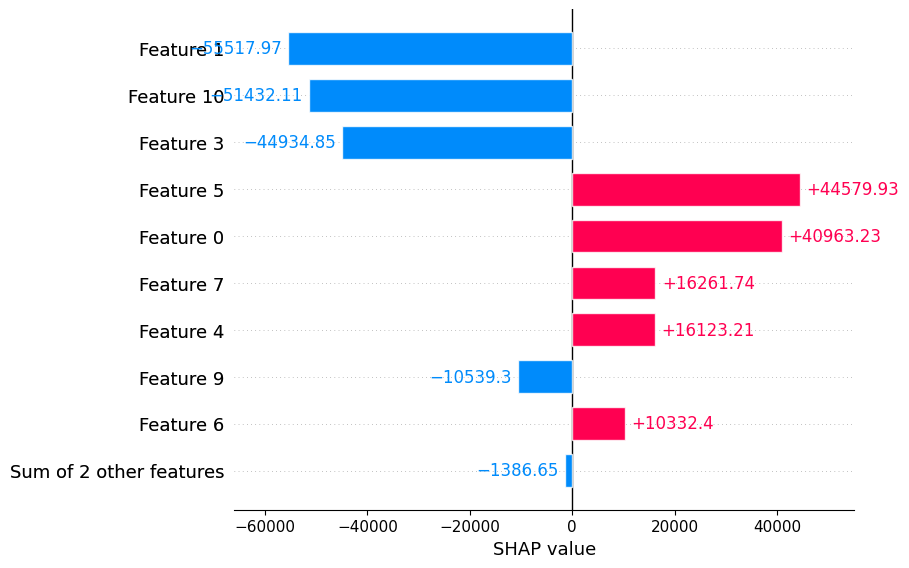

In [32]:
import shap

explainer = shap.Explainer(model.predict, X_train[0:100])
shap_values = explainer(X_train[0:100])
shap.plots.bar(shap_values[0])

Here, each point represents a row in our dataset. The farther right a point is, the more that specific feature value in that row *increased* the model prediction. The farther left a point is, the more that specific feature value in that row *decreased* the model prediction. The points are colored by feature value, with blue points representing a higher value.

For example, we can see from this plot that higher latitudes and longitudes correspond to higher house prices. Similarly, blocks with fewer total rooms or higher populations are more expensive.

## Developing Pyreal Applications: Model Transformers
Often, data needs to be transformed before being passed into a machine learning model, either to improve performance or to format it to be supported by the model architecture. For example, in the code cells above we had to one-hot encode, impute, and standardize our data in order to make model predictions on it.

Unfortunately, these kinds of transformation can make explanations hard to parse. For example, in the explanation above, we need to consider every `ocean_proximity` child feature together to get the total contribution of the actual block proximity to the ocean. Additionally, values are given are standardized values, which is difficult to parse.

By replacing these transformers with the Pyreal built-in equivalents, our explanations will be automatically presented with these muddling transformations undone. Additionally, the `MultiTypeImputer` transformer automatically imputes all columns with an appropriate strategy.

In [33]:
from pyreal.transformers import OneHotEncoder, MultiTypeImputer, DataFrameWrapper, FeatureSelectTransformer

# Initialize and fit transformers using fit_transformers
transformers = [MultiTypeImputer(),
                OneHotEncoder(columns="ocean_proximity")]

While Pyreal offers many common transformer types, sometimes our specific domains may require a more specific transformer option. Luckily, Pyreal makes it easy to add new *custom transformers*. Let's start with a basic one.

Below, we define the `PerHouseHoldAverager`. Pyreal Transformers extend the base `Transformer` class (line 3). They then define, at minimum, a `data_transform` function. This function acts just like the `.transform()` function of the sklearn transformers we used above - it takes in a dataframe, and returns the dataframe with one or more features transformed. In this case, our transformer adds a new column, with the per-household average of the requested features.

In [34]:
from pyreal.transformers import Transformer

class PerHouseholdAverager(Transformer):
    def __init__(self, columns, **kwargs):
        """
        Args:
            columns (list of strings)
                The names of the columns to average
        """
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):
        """
        Transform the data by adding a new column from total_[column] called average_[column].
        This feature represents the average value of [column] per household.

        Args:
            x (DataFrame)
                The data to transform
        """
        for column in self.columns:
            name = column.replace("total", "average")
            x[name] = x[column] / x["households"]
        return x

Let's go ahead and add that transformer to our list. You may notice the `interpret` flag in our initialization. This flag tells Pyreal that this transformation improves the *interpretability* of the resulting data - or in other words, changes the presentation of the data in such a way that makes it easier to reason about (or at least, not more difficult).

In this case, we are adding features (`average_rooms` and `average_bedrooms`) that we expect will be very easy for our users to reason about, so we do not need to undo this transformation.

In [35]:
transformers.append(PerHouseholdAverager(columns=["total_bedrooms", "total_rooms"], interpret=True))

Sometimes, there may be a way to make the data even more interpretable (ie, easy to reason about) than the original data, but that for whatever reason we do not want to or cannot make this change to the data being fed into the model.

For example, the latitude and longitude features above are hard to reason about for most people. Something like a city or neighborhood name would be better, but trying to one-hot encode every neighborhood in California to feed into the model would be a massive memory drain. Instead, we will continue giving the model the `longitude`/`latitude` features, but we will then transform the *explanation* to use this more interpretable feature.

To do so, we will use a Pyreal built-in transformer. 

In [36]:
from pyreal.transformers import LatLongToPlace

transformers.append(LatLongToPlace(result_column="neighborhood", interpret=True, model=False))

Once again, we use the `interpret` flag to indicate that this transformation makes our data more interpretable. We also add the `model=False` flag, to indicate that we should **not** apply this model when making model predictions.

We will also add two additional Pyreal built-in transformers, to improve model performance. Pyreal transformers are run in the order they appear in the transformer list, so we need to be careful about our order. The `DataFrameWrapper` wraps a standard scaler, allowing us to standardize all features while maintaining the DataFrame data type and column names. Finally, the `FeatureSelectTransformer` will reorder columns to ensure they are in the order expected by the model.


### Custom Transformers: Summary

In summary, when defining custom Pyreal transformers, we take the following steps:
1. Define the transformer `__init__()` method, using a `super()` call for the parent `Transformer` class. The function can take optional arguments to configure the transformer.
2. Define the `data_transform()` function, which takes an input DataFrame `x` and returns `x` after undergoing the transformation.
3. Consider the explanation output types you are interested in, and define the appropriate explanation transforms. In the above example, we considered additive local feature contribution and additive global feature importance explanations. We therefore defined the `transform_explanation_additive_feature_contribution` and `transform_explanation_additive_feature_importance` functions.
4. [**Advanced Additional Step**]: The explanation transform functions used above are used to transform the explanation to match the feature space resulting from the data transform function. In some cases, like in Pyreal's built-in one-hot encoder transformer, we may want to *undo* the transformation in the explanation. In these cases, we would define `inverse_transform_explanation_XXX` functions. See the Pyreal documentation for more details about this.

## Initializing RealApps

Now that we have our model transformers, we can gather the other components of the application:
 - [`model`]: We train our machine learning model using the external system of our choice.
 - [`feature_descriptions`]: This optional parameter is dictionary of feature names (ie, the data columns) to descriptions, which we can use if our feature names are not naturally readable.

In [37]:
from pyreal import RealApp

transformers.append(DataFrameWrapper(StandardScaler()))
transformers.append(FeatureSelectTransformer(columns=expected_column_order))

feature_descriptions = california_housing.load_feature_descriptions()
print(feature_descriptions)

real_app = RealApp(model, X_train_orig=X, y_train=y, transformers=transformers, fit_transformers=True, feature_descriptions=feature_descriptions)

{'longitude': 'Longitude', 'latitude': 'Latitude', 'housing_median_age': 'Median house age', 'total_rooms': 'Total # of Rooms', 'total_bedrooms': 'Total # of Bedrooms', 'population': 'Population', 'households': 'Number of Households', 'median_income': 'Median Income', 'ocean_proximity': 'Proximity to Ocean', 'neighborhood': 'Neighborhood', 'average_bedrooms': 'Average # of Bedrooms Per Household', 'average_rooms': 'Average # of Rooms Per Household'}


We can now use the `real_app` object's `produce` functions to get explanations.

In [38]:
house_of_interest = X.iloc[0]
prediction = real_app.predict(house_of_interest)

X has feature names, but MLPRegressor was fitted without feature names


In [39]:
explanation = real_app.produce_feature_contributions(house_of_interest, shap_type="kernel", training_size=100)

  0%|          | 0/1 [00:00<?, ?it/s]

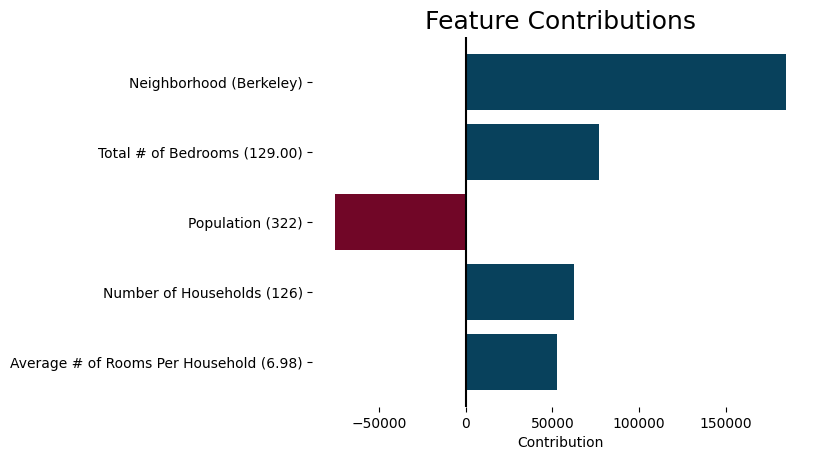

In [40]:
from pyreal import visualize
 
visualize.feature_bar_plot(explanation)

We can also take a look at similar houses from the dataset, and then predictions

In [41]:
similar_house = real_app.produce_similar_examples(house_of_interest, num_examples=1)
print("Most similar house from dataset, predicted at $%.2f" % similar_house["y"].iloc[0])
similar_house["X"]

Most similar house from dataset, predicted at $452600.00


,Median house age,Total # of Rooms,Total # of Bedrooms,Population,Number of Households,Median Income,Proximity to Ocean,Average # of Bedrooms Per Household,Average # of Rooms Per Household,Neighborhood
0,41,880,129.0,322,126,8.3252,NEAR BAY,1.02381,6.984127,Berkeley
